In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, mutual_info_regression, SelectPercentile, VarianceThreshold
from scipy.stats import norm, skew
from scipy.special import boxcox1p

# Loading the data

In [2]:
# load dataset 
csv_path = "challenge_house_pricing/data.csv"
dataset = pd.read_csv(csv_path, sep = ',')  

# check shape
dataset.shape

(1460, 81)

In [3]:
# Checking the columns (features)
dataset.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
# Drop id as it is not required for training or prediction
dataset.drop(['Id'], axis=1, inplace=True)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### Note: There are three different data types in the dataframe: float64, int64 and object. These can be categorized into numerical and categorical features

# Correlation analysis

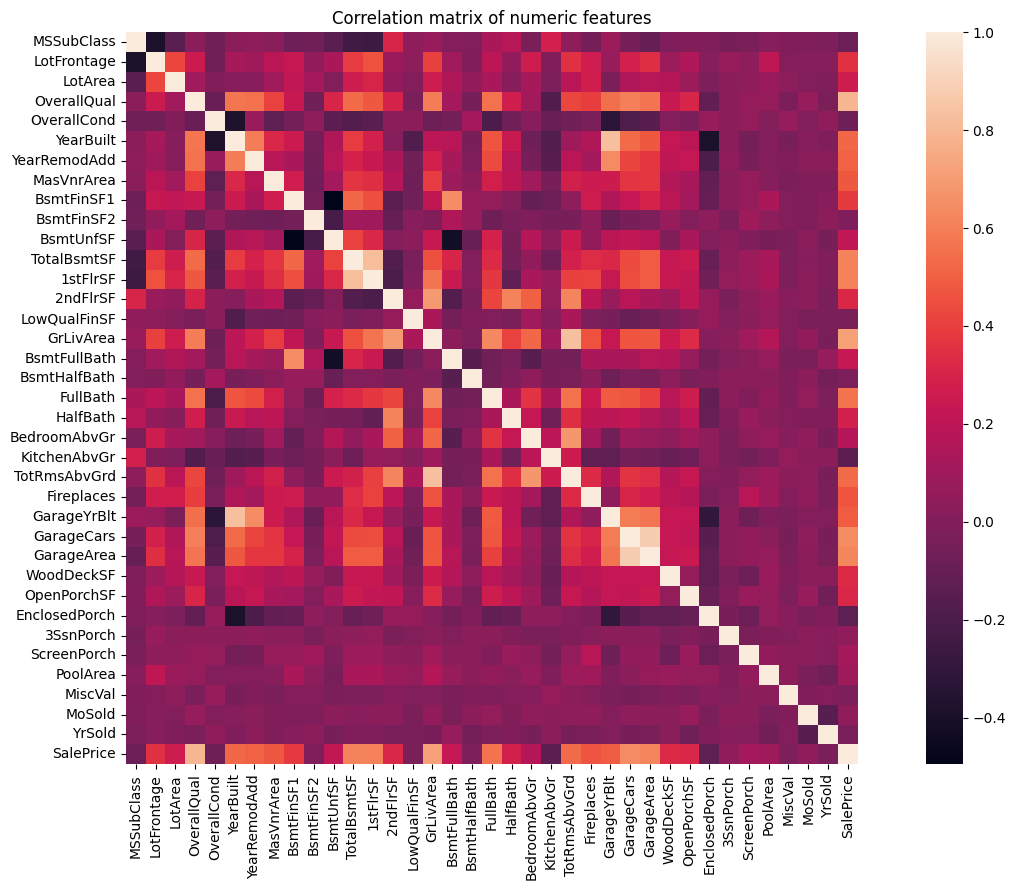

In [6]:
# Correlation matrix

corr_mat = dataset.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(14, 9), tight_layout=True)
sns.heatmap(corr_mat, vmax=1.0, square=True)
plt.title("Correlation matrix of numeric features");

In [7]:
## Analysing pairs of highly correlated numerical features

highly_correlated = set()

for i in range(len(corr_mat.columns)):
    for j in range(i):
        if abs(corr_mat.iloc[i, j]) > 0.8:
            colname = corr_mat.columns[i]
            colname2 = corr_mat.columns[j]
            highly_correlated.add((colname, colname2))

for col1, col2 in highly_correlated:
    print(f"{col1} and {col2} are highly correlated with a correlation of {corr_mat.loc[col1, col2]}")


GarageYrBlt and YearBuilt are highly correlated with a correlation of 0.8256674841743408
TotRmsAbvGrd and GrLivArea are highly correlated with a correlation of 0.8254893743088425
1stFlrSF and TotalBsmtSF are highly correlated with a correlation of 0.8195299750050339
GarageArea and GarageCars are highly correlated with a correlation of 0.882475414281462


## Most correlated features

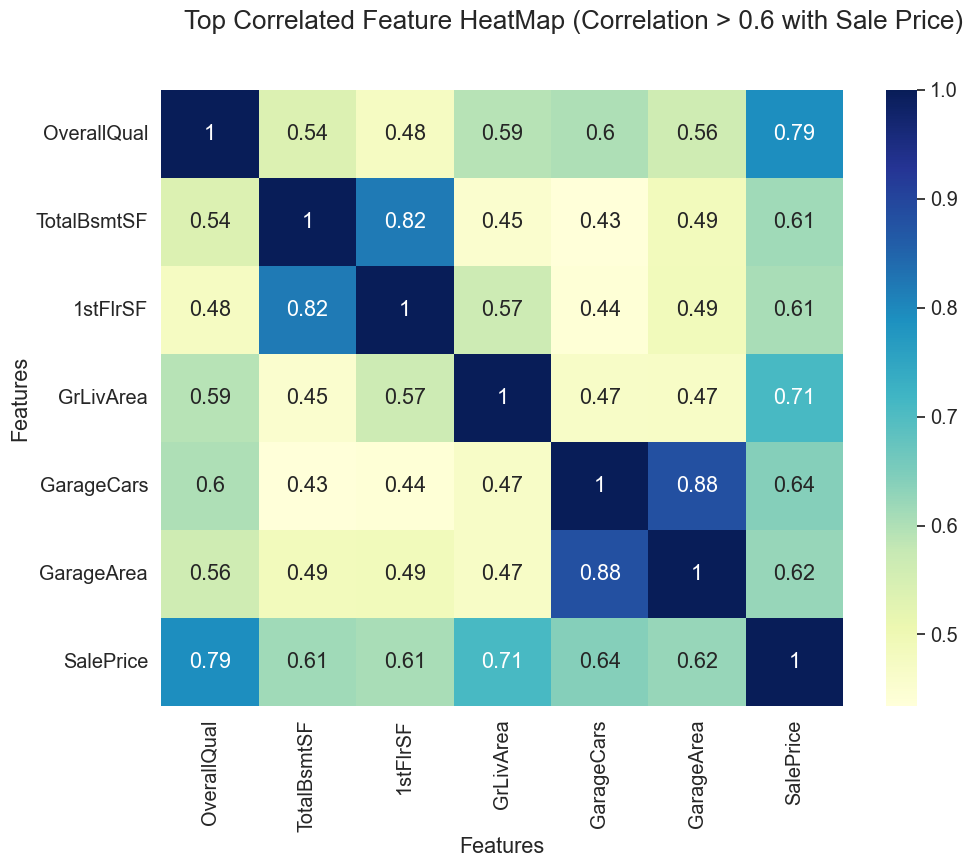

In [8]:
# most correlated features with SalePrice

corr_mat = dataset.corr(numeric_only=True)
threshold = 0.6
sns.set(font_scale=1.3)
plt.figure(figsize=(11,8))

top_corr = corr_mat.index[abs(corr_mat["SalePrice"]) > threshold]
g = sns.heatmap(dataset[top_corr].corr(), annot=True, cmap="YlGnBu")

plt.suptitle(f"Top Correlated Feature HeatMap (Correlation > {threshold} with Sale Price)")
plt.xlabel("Features")
plt.ylabel("Features");

### Note: OverallQual, GrLicArea, GarageCars, TotalBsmtSF and 1stFlrSF are the most correlated features with the SalePrice. 

## Least correlated features

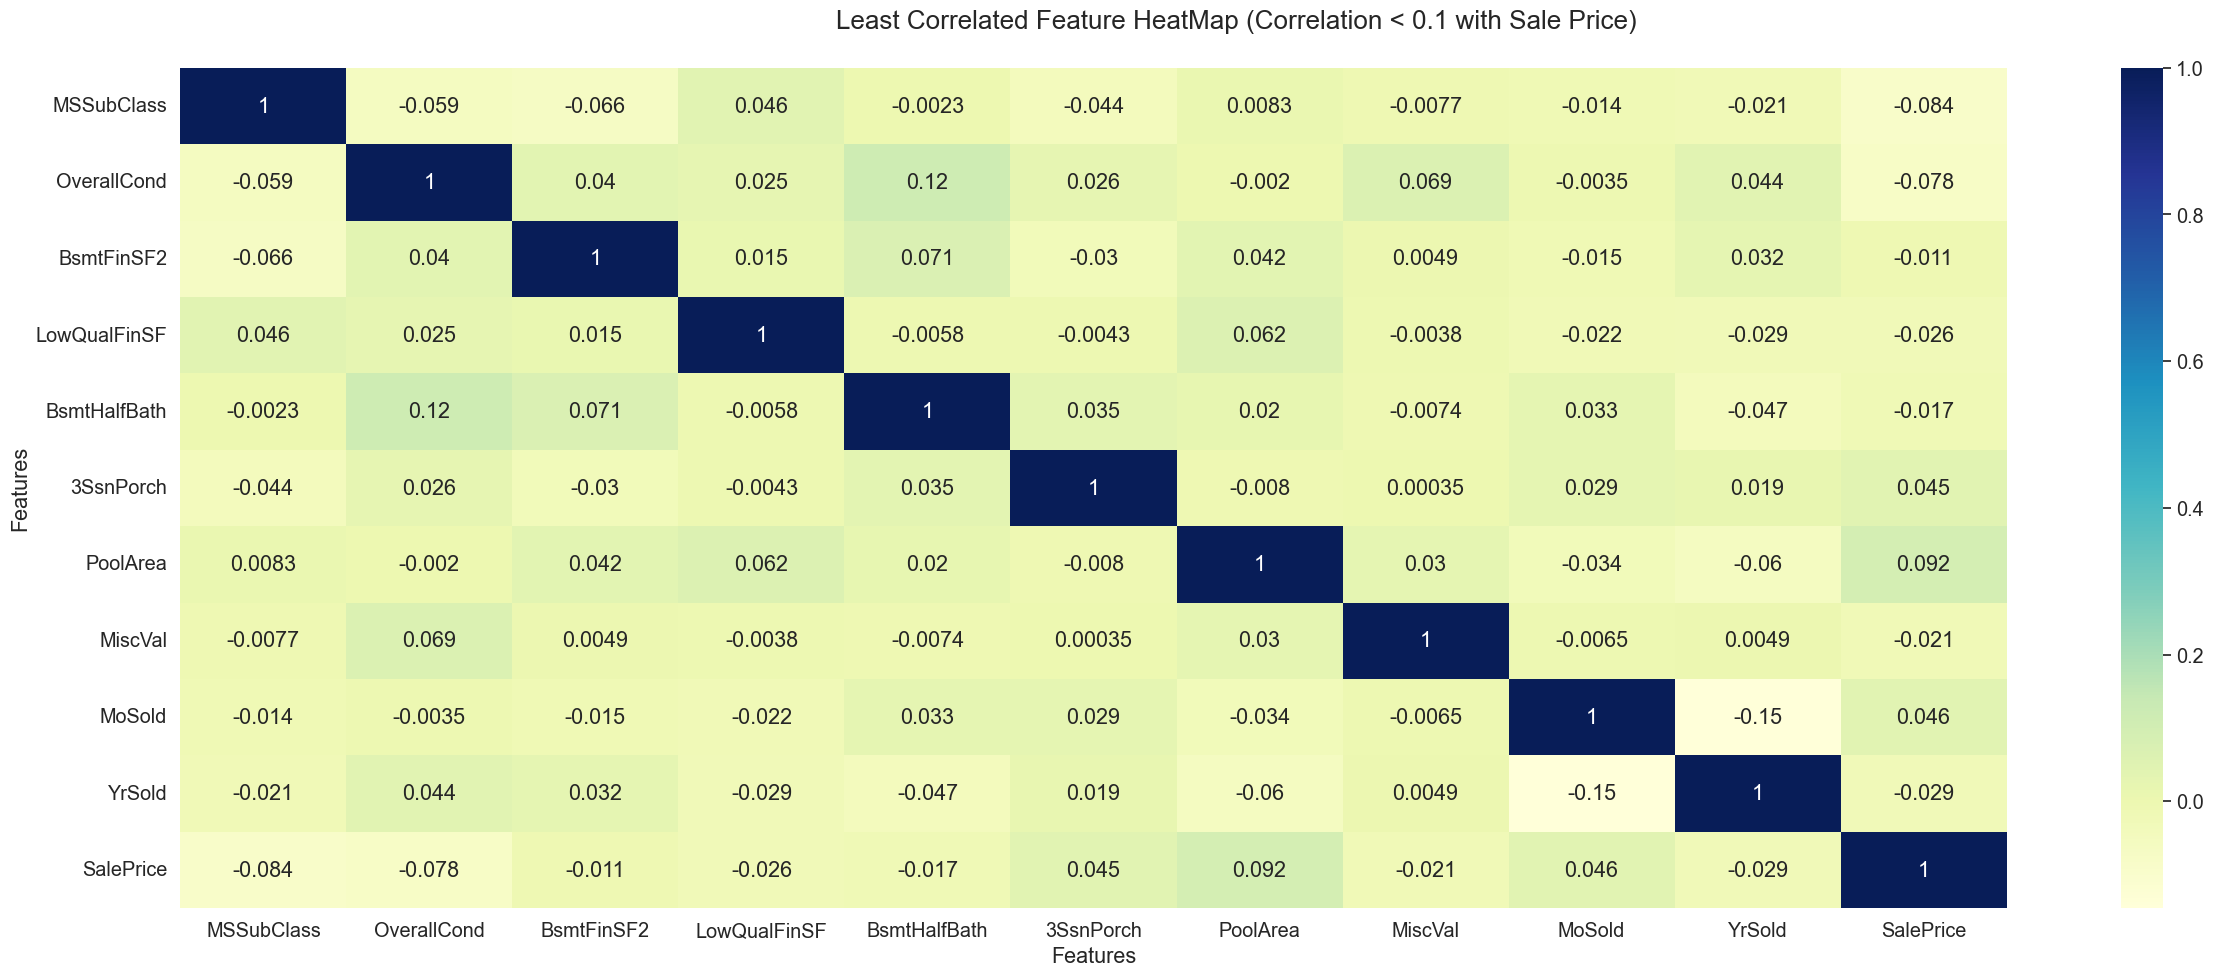

In [10]:
threshold = 0.1
least_corr = corr_mat.index[abs(corr_mat["SalePrice"])<threshold]
least_corr = least_corr.append(pd.Index(["SalePrice"]))
fig, ax = plt.subplots(figsize=(25, 10), tight_layout=True)
g = sns.heatmap(dataset[least_corr].corr(),annot=True,cmap="YlGnBu")

plt.suptitle(f"Least Correlated Feature HeatMap (Correlation < {threshold} with Sale Price)")
plt.xlabel("Features")
plt.ylabel("Features");

## drop the least correlated features

In [11]:
least_corr = least_corr.drop("SalePrice")
print("least_corr: ", least_corr)
dataset.drop(least_corr, axis=1, inplace=True)

least_corr:  Index(['MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF',
       'BsmtHalfBath', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')


<Axes: >

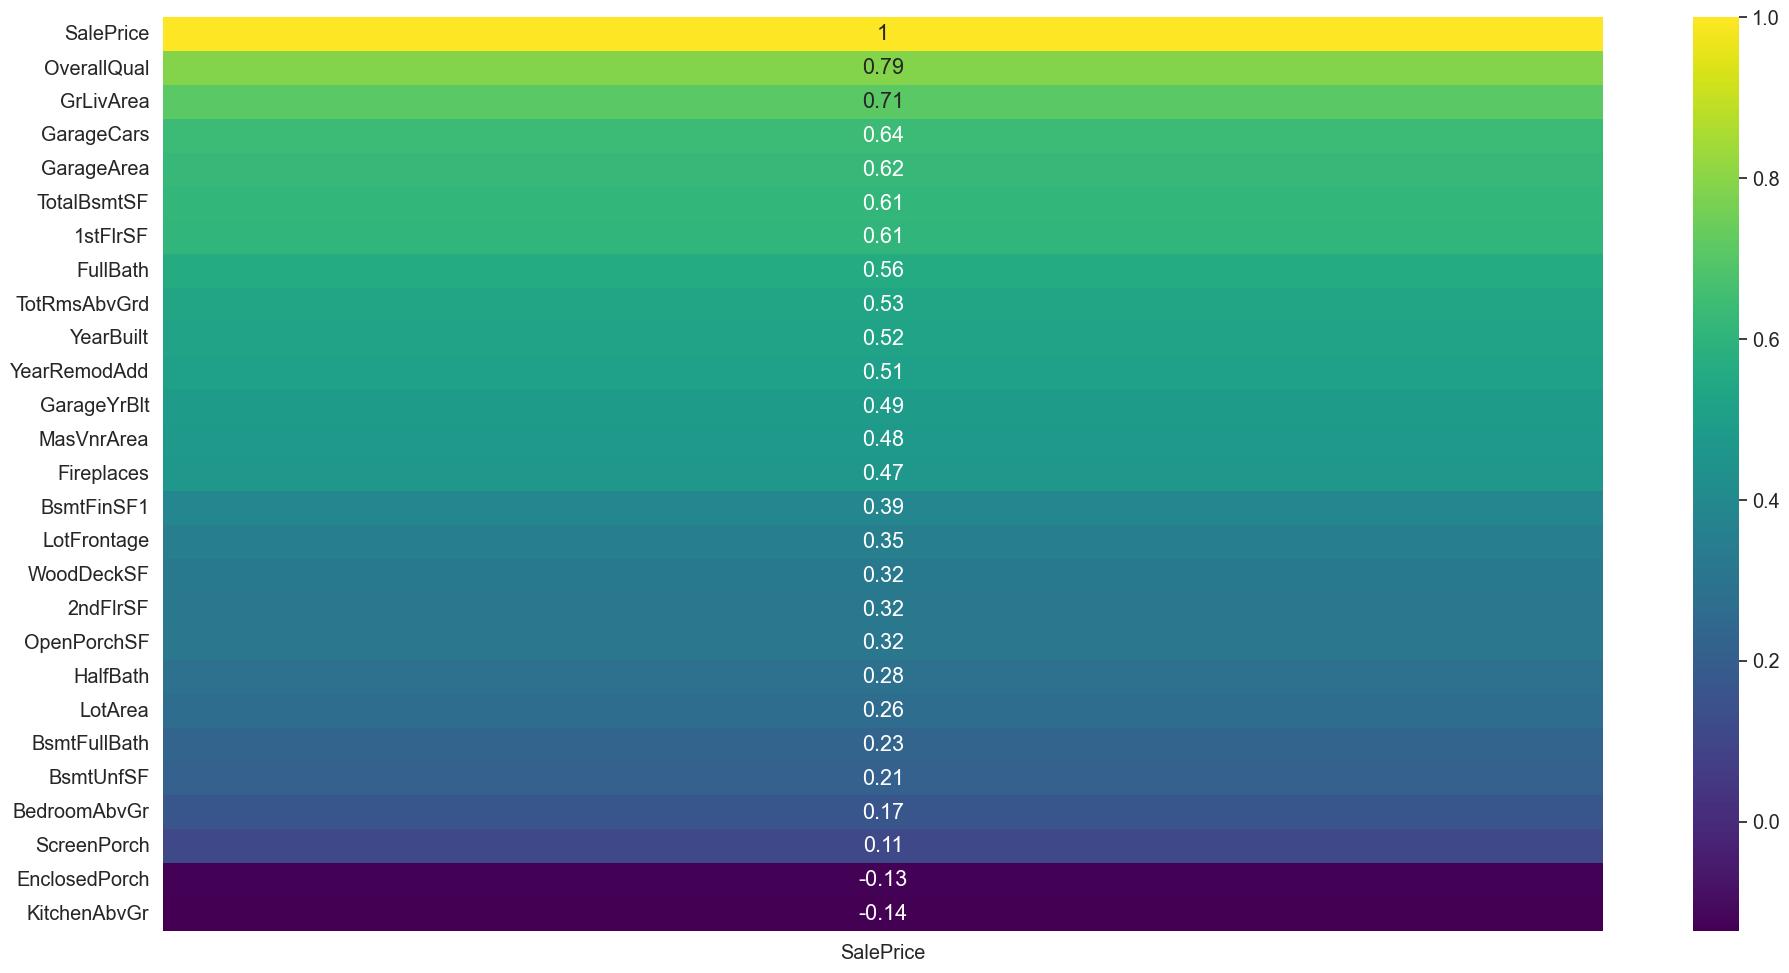

In [12]:
plt.figure(figsize=(20, 10), tight_layout=True)
sns.heatmap(dataset.corr(numeric_only=True)[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap='viridis')

# Outlier analysis

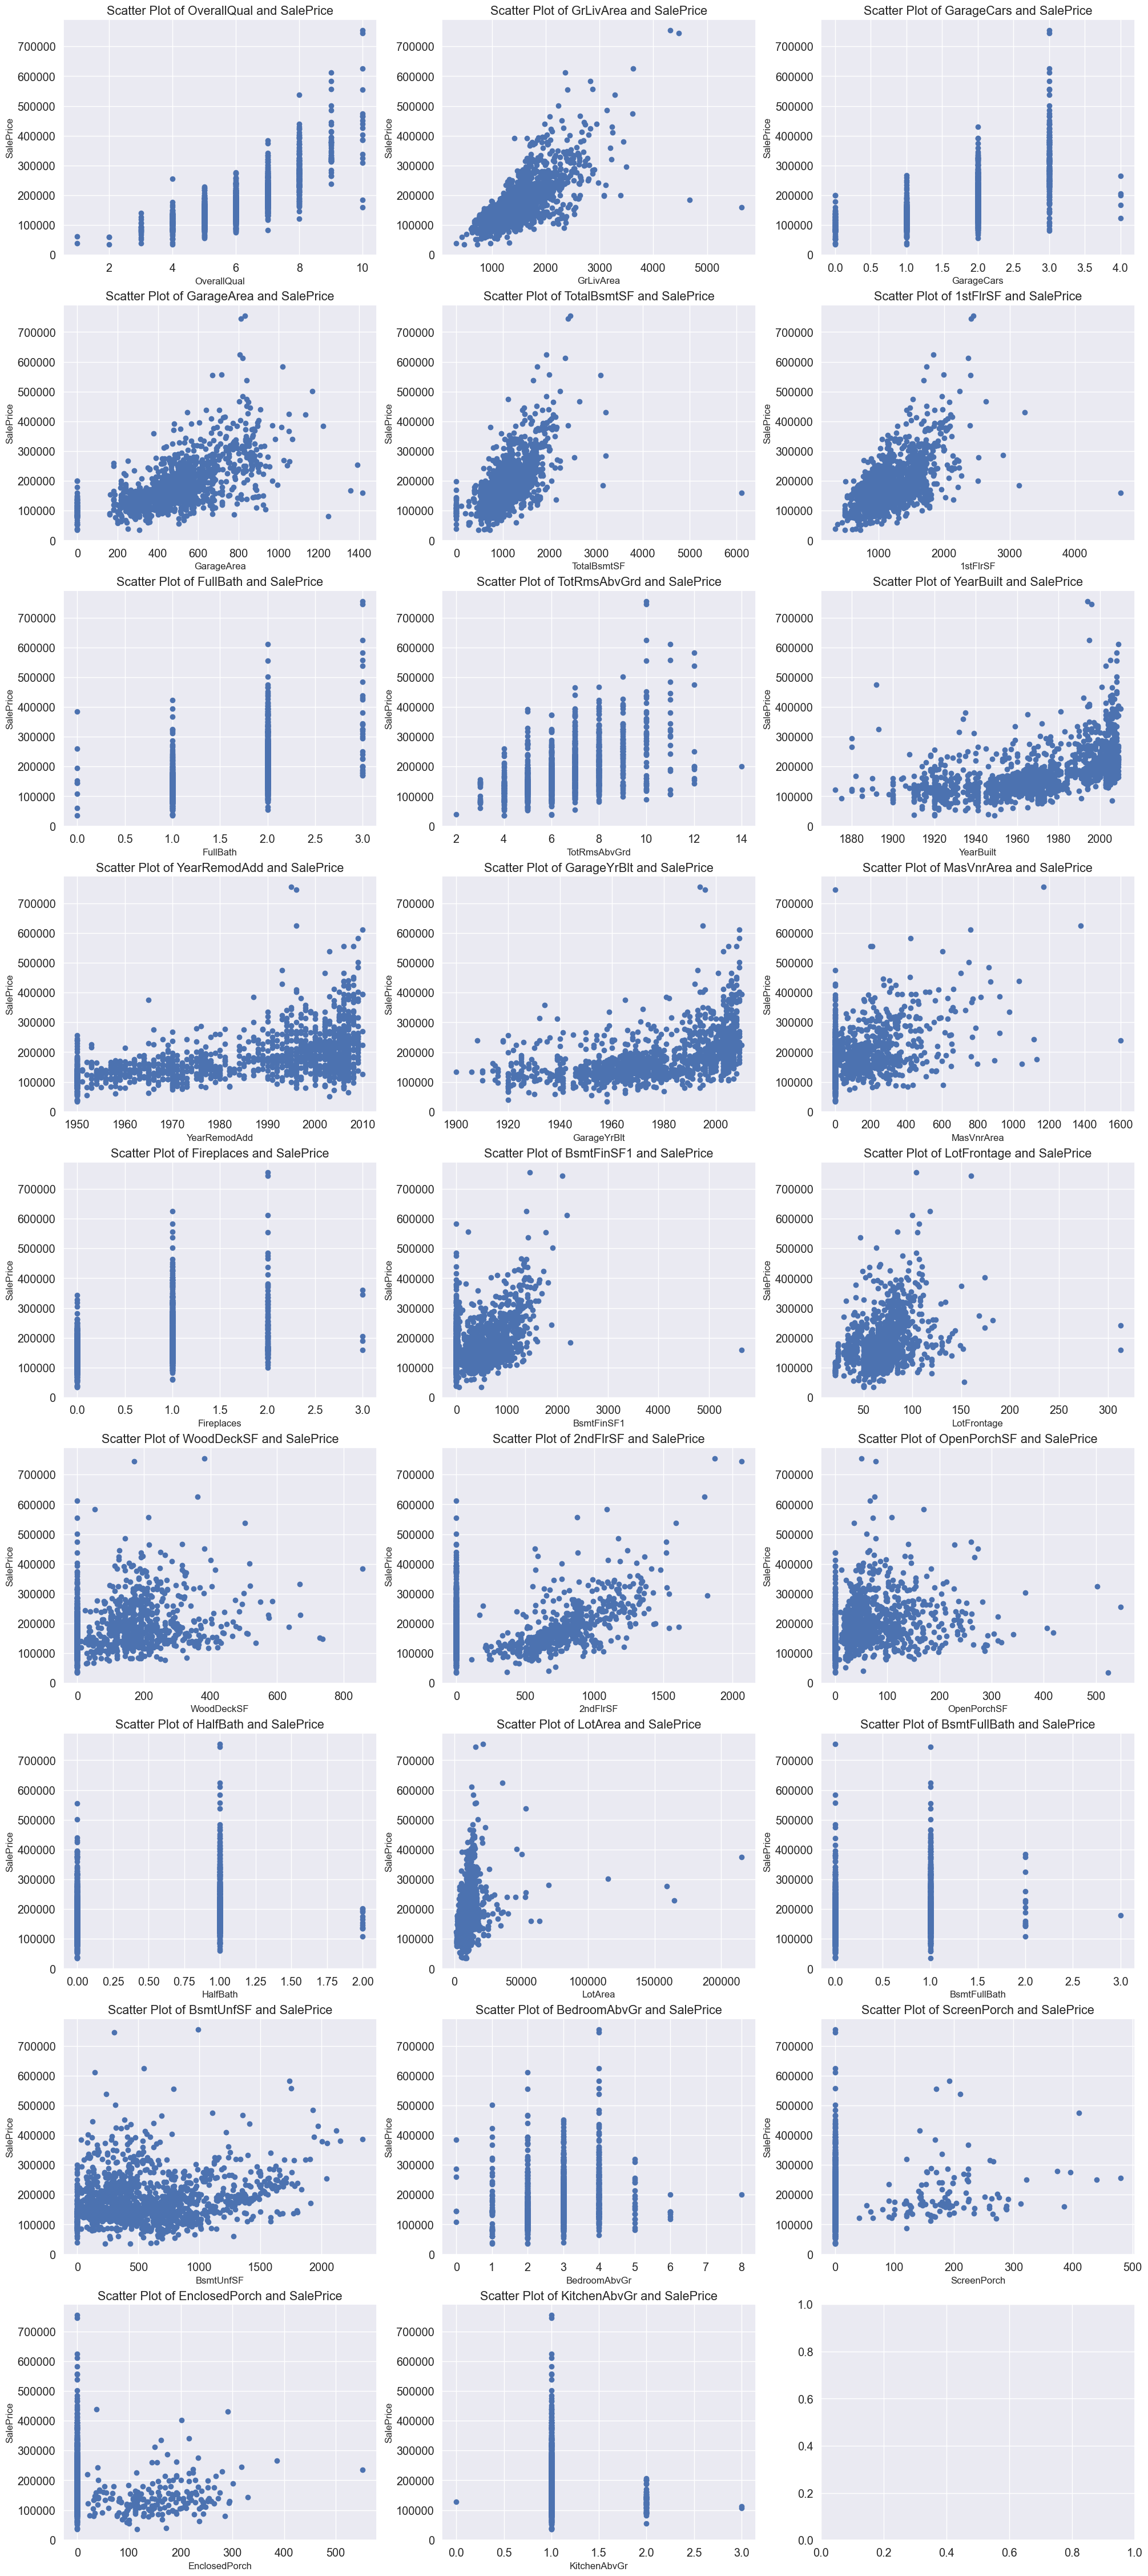

In [13]:
corr = dataset.corr(numeric_only=True).drop('SalePrice')
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
corr.SalePrice

features = corr.SalePrice.index.values

# Determine the number of rows based on the number of features
num_features = len(features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns  # Calculate the number of rows

fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows), constrained_layout=True)

for i, x in enumerate(features):
    row = i // num_columns  # Calculate the row index
    col = i % num_columns   # Calculate the column index

    axs[row,col].scatter(x = dataset[x], y = dataset['SalePrice'])
    axs[row, col].set_ylabel('SalePrice', fontsize=12)
    axs[row, col].set_xlabel(x, fontsize=12)
    axs[row, col].set_title("Scatter Plot of "+ x + " and SalePrice")

plt.show();


## deleting outliers

In [14]:
dataset.drop( dataset[( dataset['GrLivArea'] > 4000) & (dataset['SalePrice'] < 300_000)].index, inplace = True)
# dataset.drop( dataset[( dataset['1stFlrSF'] > 4000)].index, inplace = True)
# dataset.drop( dataset[( dataset['LowQualFinSF'] > 500) & (dataset['SalePrice'] > 500_000)].index, inplace = True)
# dataset.drop( dataset[( dataset['MasVnrArea'] > 1200)].index, inplace = True)
# dataset.drop( dataset[( dataset['BsmtFinSF1'] > 3000)].index, inplace = True)
# dataset.drop( dataset[( dataset['BsmtFinSF2'] > 1200)].index, inplace = True)
# dataset.drop( dataset[( dataset['MiscVal'] > 4000)].index, inplace = True)
# dataset.drop( dataset[( dataset['EnclosedPorch'] > 400)].index, inplace = True)
# dataset.drop( dataset[( dataset['KitchenAbvGr'] <= 0.5)].index, inplace = True)
# dataset.drop( dataset[( dataset['KitchenAbvGr'] >= 2.5)].index, inplace = True)
# dataset.drop( dataset[( dataset['SalePrice'] > 700_000)].index, inplace = True)
# dataset.drop( dataset[( dataset['LotFrontage'] > 200)].index, inplace = True)


dataset.reset_index(inplace=True, drop=True)

In [15]:
dataset.columns

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ScreenPorch', 'PoolQC', 'Fence'

# Imputing missing values

In [16]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    dataset[col].fillna('None', inplace=True)

In [17]:
# Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageYrBlt', 'GarageCars'):
    dataset[col].fillna(0, inplace=True)

In [18]:
# missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath'):
    dataset[col].fillna(0, inplace=True)

In [19]:
# For all these categorical basement-related features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    dataset[col].fillna('None', inplace=True)

In [20]:
# NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
dataset["MasVnrType"].fillna("None", inplace=True)
dataset["MasVnrArea"].fillna(0, inplace=True)

In [21]:
# 'RL' is by far the most common value. So we can fill in missing values with 'RL'
dataset['MSZoning'].fillna(dataset['MSZoning'].mode()[0], inplace=True)

In [22]:
# Most values are "AllPub". We can drop this feature.
dataset.drop('Utilities', axis=1, inplace=True)

In [23]:
# Functional : data description says NA means typical
dataset["Functional"].fillna("Typ", inplace=True)

In [24]:
#  It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
dataset['Electrical'].fillna(dataset['Electrical'].mode()[0], inplace=True)

In [25]:
# Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
dataset['KitchenQual'].fillna(dataset['KitchenQual'].mode()[0], inplace=True)

In [26]:
# Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
dataset['Exterior1st'].fillna(dataset['Exterior1st'].mode()[0], inplace=True)
dataset['Exterior2nd'].fillna(dataset['Exterior2nd'].mode()[0], inplace=True)

In [27]:
# Fill in with most frequent which is "WD"
dataset['SaleType'].fillna(dataset['SaleType'].mode()[0], inplace=True)

In [29]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
dataset["LotFrontage"] = dataset.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# Converting numerical variables to categorical

In [30]:
dataset.columns

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolQC',
       'Fence', 'MiscFeatur

In [31]:
# MSSubClass: The building class
# dataset['MSSubClass'] = dataset['MSSubClass'].apply(str)

# Year and month sold are transformed into categorical features.
# dataset['YrSold'] = dataset['YrSold'].astype(str)
# dataset['MoSold'] = dataset['MoSold'].astype(str)

dataset['GarageYrBlt'] = dataset['GarageYrBlt'].astype(str)
dataset['YearRemodAdd'] = dataset['YearRemodAdd'].astype(str)

# Adding new features (feature engineering)

In [32]:
dataset['TotalSF'] = dataset['TotalBsmtSF'] + dataset['1stFlrSF'] + dataset['2ndFlrSF']

# dataset['Total_Home_Quality'] = dataset['OverallQual'] + dataset['OverallCond']

# dataset['haspool'] = dataset['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

dataset['has2ndfloor'] = dataset['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

dataset['hasgarage'] = dataset['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

dataset['hasbsmt'] = dataset['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

dataset['hasfireplace'] = dataset['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [33]:
df = dataset.copy()

In [34]:
null_train = df.isnull().sum()
null_train[null_train>0].sort_values(ascending=False)

PoolQC         1452
MiscFeature    1404
Alley          1367
Fence          1177
FireplaceQu     690
dtype: int64

## Skewed features

In [36]:
df_numeric = df.select_dtypes(exclude=['object']).drop(['SalePrice'], axis=1)
df_categories = df.select_dtypes(include=['object'])

In [37]:
df_numeric.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ScreenPorch', 'TotalSF', 'has2ndfloor', 'hasgarage', 'hasbsmt',
       'hasfireplace'],
      dtype='object')

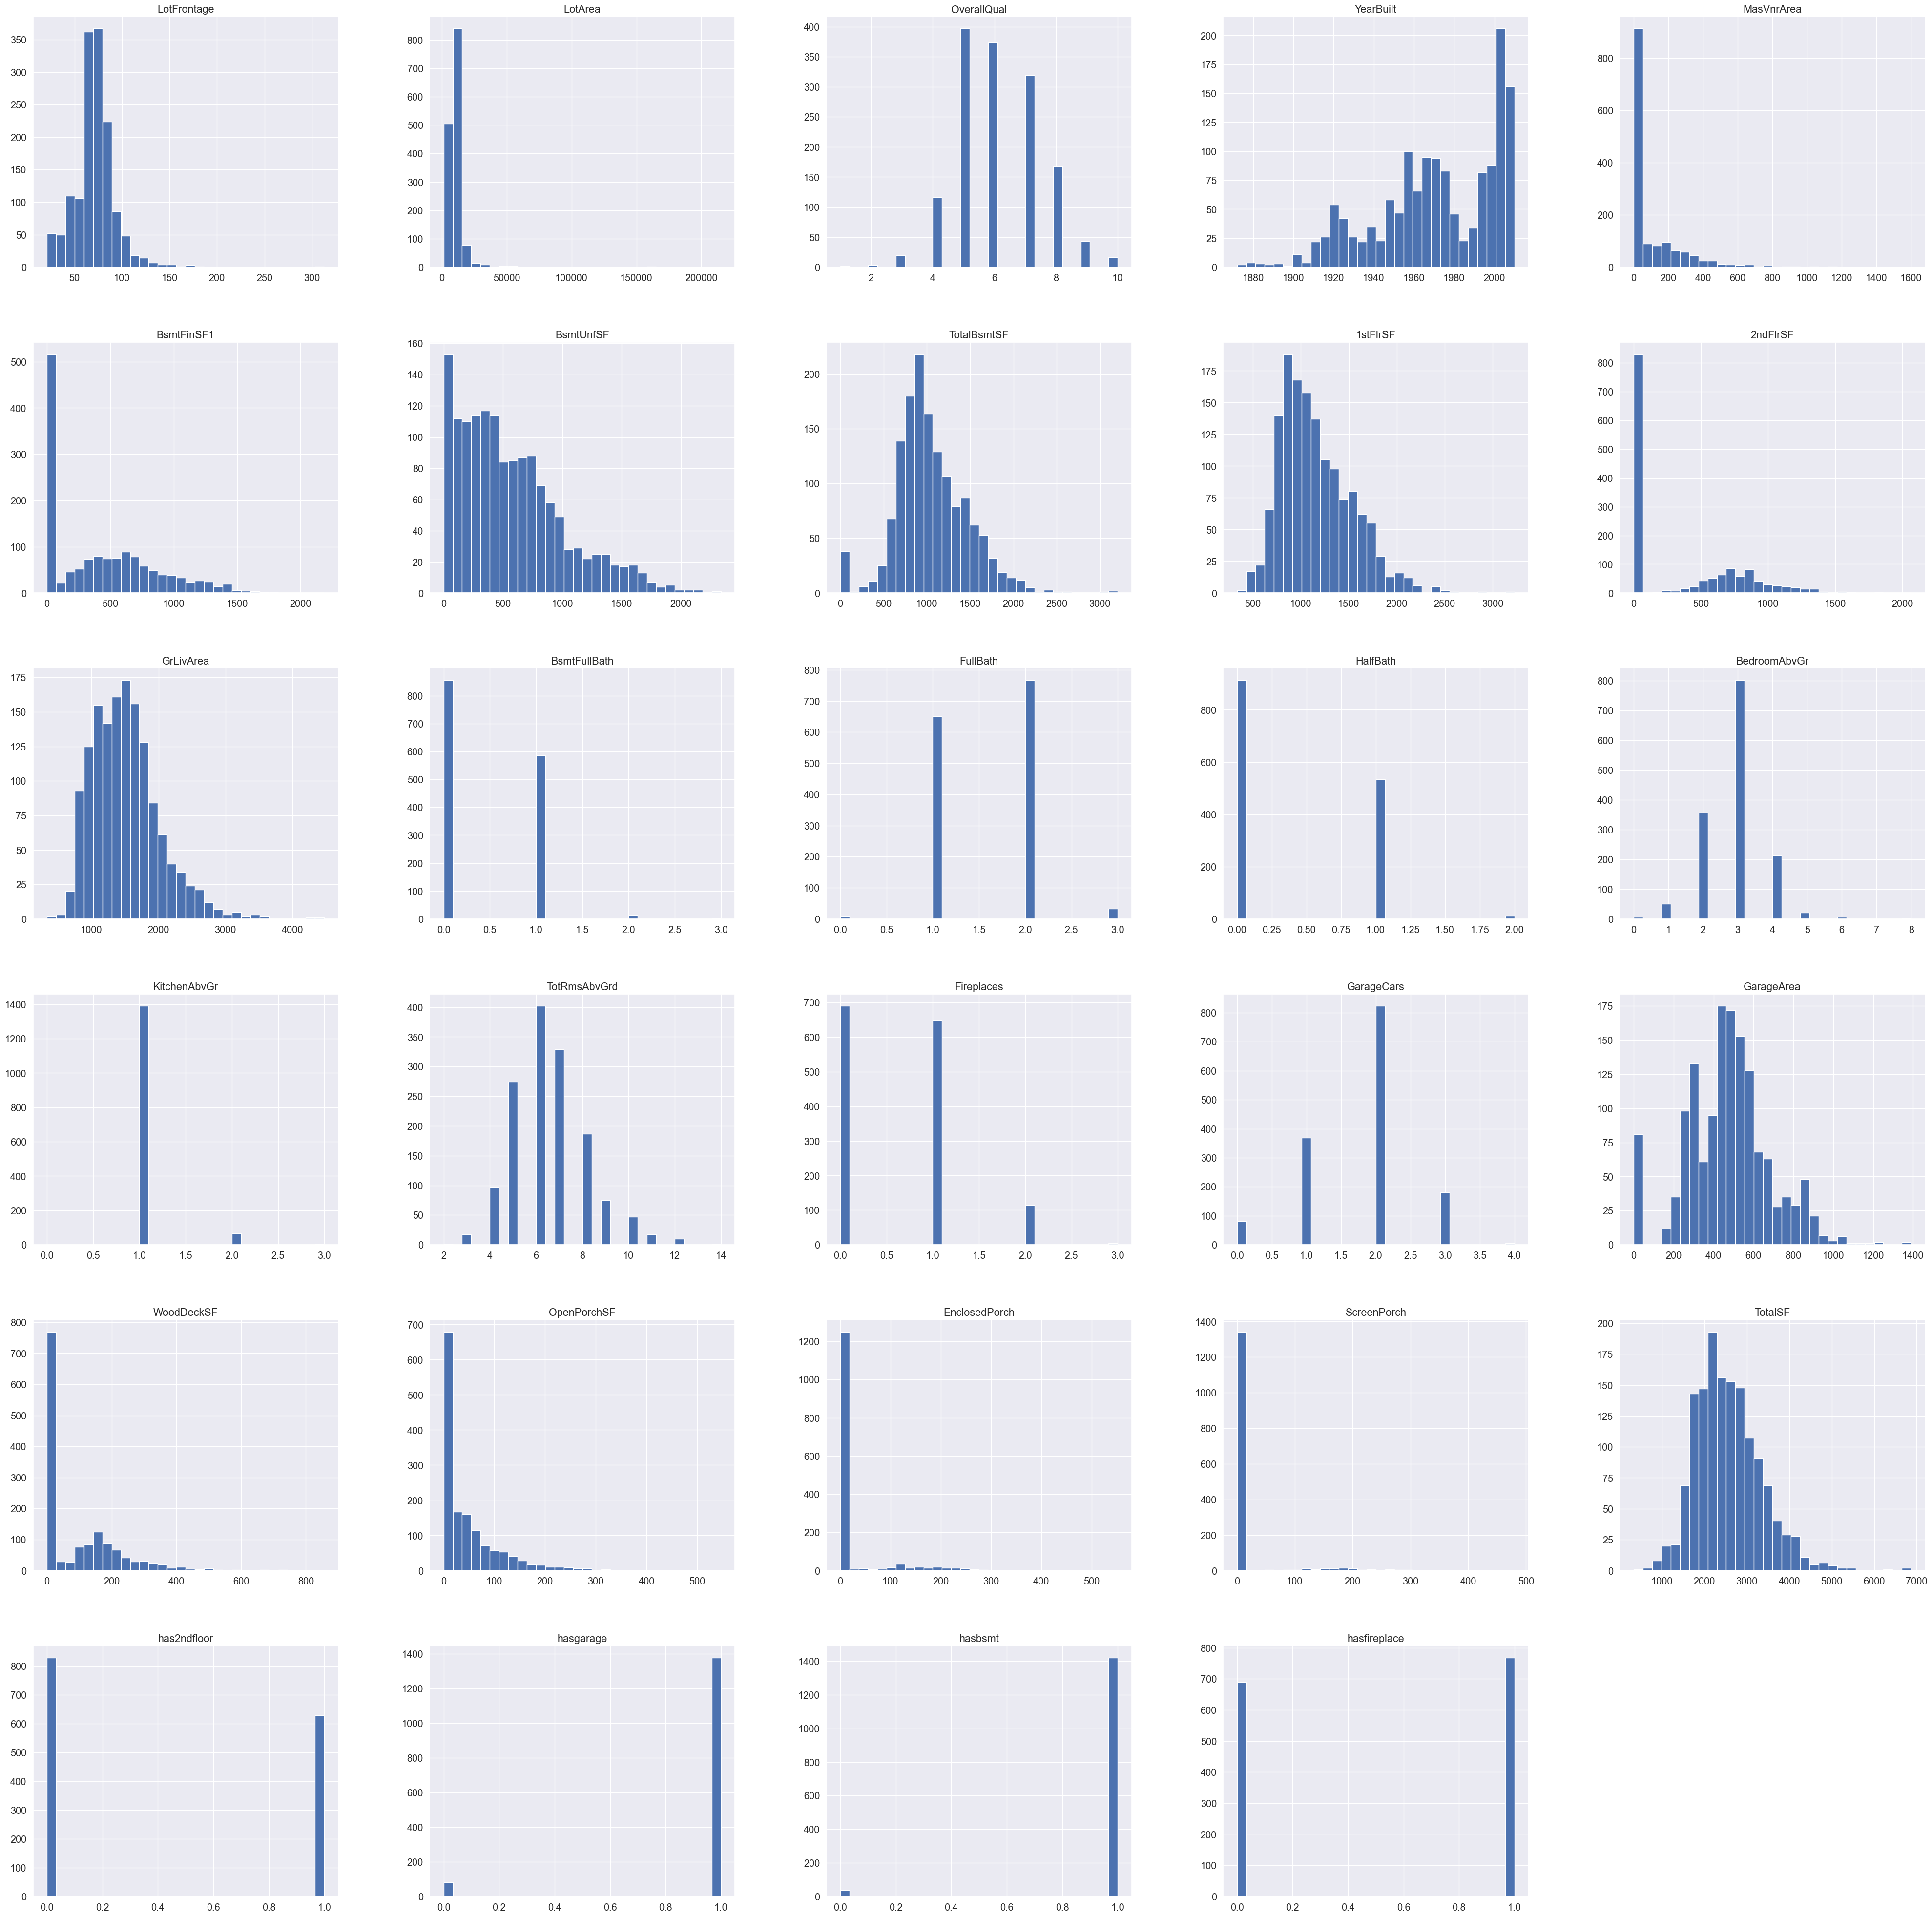

In [38]:
ax = df_numeric.hist(bins=30, figsize=(50, 50))  #inspecting the distributions to get ideas on handling NAs/Outliers
plt.show()

In [39]:
skewed_feats = df_numeric.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats

print("Skew in numerical features:")
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness.head(10))

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
print("skewed_features: ", skewed_features)
lam = 0.15
for feat in skewed_features:
    df_numeric[feat] = boxcox1p(df_numeric[feat], lam)

Skew in numerical features:
                    Skew
LotArea        12.560986
KitchenAbvGr    4.480268
ScreenPorch     4.114690
EnclosedPorch   3.083987
MasVnrArea      2.693554
OpenPorchSF     2.337421
LotFrontage     1.546624
WoodDeckSF      1.544214
GrLivArea       1.009951
BsmtUnfSF       0.919955
There are 29 skewed numerical features to Box Cox transform
skewed_features:  Index(['LotArea', 'KitchenAbvGr', 'ScreenPorch', 'EnclosedPorch', 'MasVnrArea',
       'OpenPorchSF', 'LotFrontage', 'WoodDeckSF', 'GrLivArea', 'BsmtUnfSF',
       '1stFlrSF', '2ndFlrSF', 'TotalSF', 'BsmtFinSF1', 'HalfBath',
       'TotRmsAbvGrd', 'Fireplaces', 'BsmtFullBath', 'TotalBsmtSF',
       'has2ndfloor', 'BedroomAbvGr', 'OverallQual', 'GarageArea', 'FullBath',
       'hasfireplace', 'GarageCars', 'YearBuilt', 'hasgarage', 'hasbsmt'],
      dtype='object')


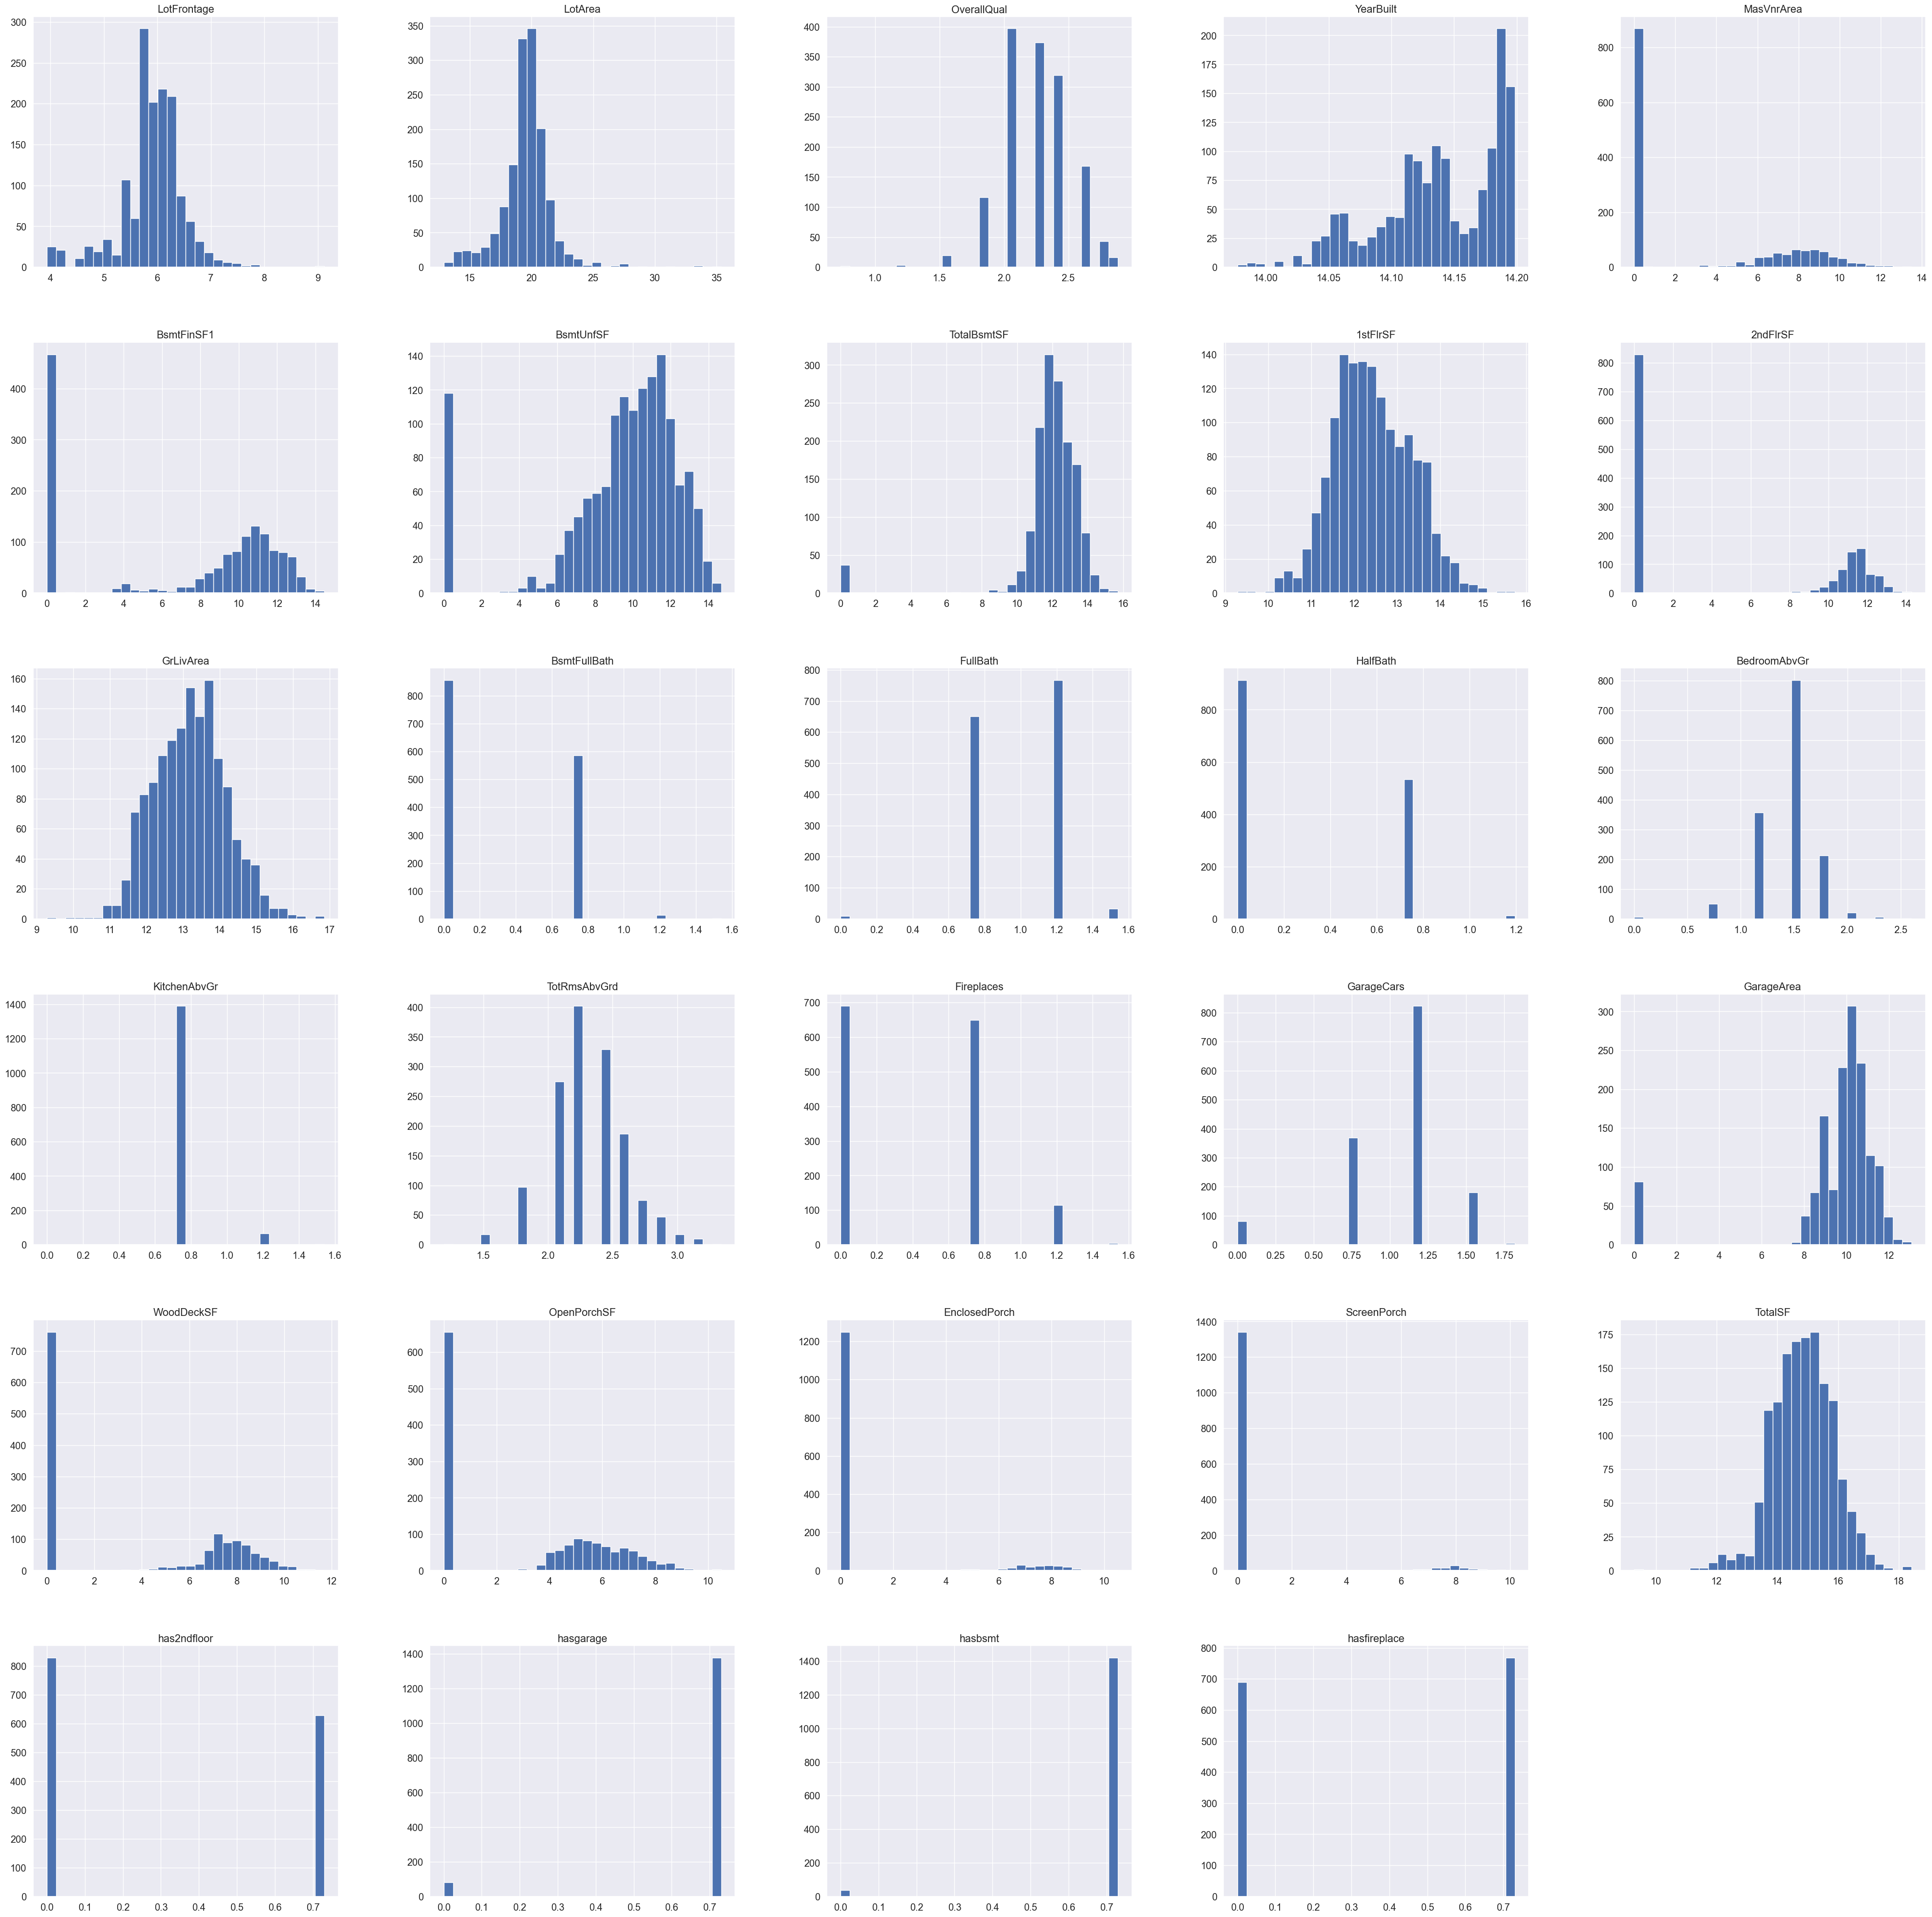

In [40]:
ax = df_numeric.hist(bins=30, figsize=(50, 50))  #inspecting the distributions to get ideas on handling NAs/Outliers
plt.show()

## Mutual info to select top numerical features

before dropping:  29
features to be dropped:  Index(['BsmtFullBath', 'KitchenAbvGr', 'EnclosedPorch', 'ScreenPorch',
       'has2ndfloor', 'hasbsmt'],
      dtype='object')
after dropping:  23


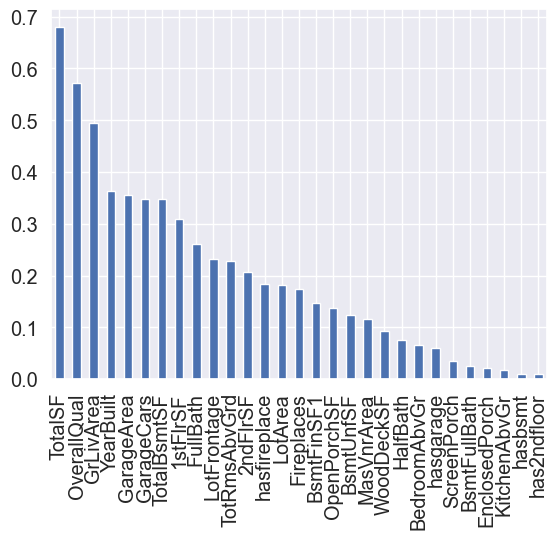

In [41]:
X_numeric = df_numeric.fillna(0)
y = df['SalePrice']

mutual_info = mutual_info_regression(X_numeric, y)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_numeric.columns
mutual_info.sort_values(ascending=False,inplace=True)

mutual_info.plot(kind='bar');

# Now we will select top 25 important features
sel_top_features = SelectPercentile(mutual_info_regression, percentile=80)
sel_top_features.fit(X_numeric, y)
sel_top_features.get_support()

X_numeric.columns[sel_top_features.get_support()]
print("before dropping: ",len(df_numeric.columns))
print("features to be dropped: ",X_numeric.columns[~sel_top_features.get_support()])
df_numeric.drop(X_numeric.columns[~sel_top_features.get_support()], axis=1, inplace=True)
print("after dropping: ",len(df_numeric.columns))


## Label encoding or get dummies 

In [42]:
df_categories.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [43]:
df_categories_encoded = pd.get_dummies(df_categories, drop_first=True)

## Chi square test

In [44]:
# chi2 returns 2 values: Fscore, pvalue
# Higher the Fscore, more important is the feature.
# Lower the pvalue, more important is the feature.
Fscore, pvalue = chi2(df_categories_encoded,y)

# Converting into Series and sorting
Fscore = pd.Series(Fscore)
Fscore.index = df_categories_encoded.columns
Fscore.sort_values(ascending=False,inplace=True)

pvalue = pd.Series(pvalue)
pvalue.index = df_categories_encoded.columns
pvalue.sort_values(ascending=True,inplace=True)

print("columns to be dropped: ", df_categories_encoded.columns[Fscore<100])
df_categories_encoded = df_categories_encoded.drop(columns=df_categories_encoded.columns[Fscore<100])

columns to be dropped:  Index(['MiscFeature_Shed', 'MiscFeature_TenC', 'SaleType_CWD', 'SaleType_Con',
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New',
       'SaleType_Oth', 'SaleType_WD', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object')


## Concat numerical and categorical features

In [45]:
df_numeric["SalePrice"] = df["SalePrice"]

In [46]:
df_final = pd.concat(objs=[df_categories_encoded, df_numeric], axis=1)

In [47]:
df_final.shape

(1458, 382)

## Transform price to log

Text(0.5, 0.98, 'Distribution of Sale Price')

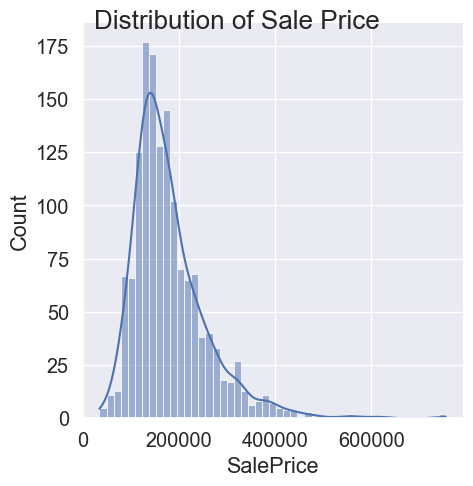

In [48]:
sns.displot(
    data = df_final,
    x = 'SalePrice',
    kde = True,
)

plt.suptitle( "Distribution of Sale Price")

In [49]:
df_final["SalePrice"] = np.log1p(df_final["SalePrice"])

Text(0.5, 0.98, 'Distribution of Sale Price log')

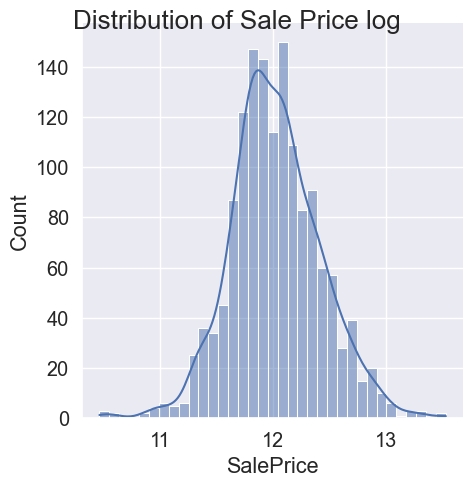

In [50]:
sns.displot(
    data = df_final,
    x = 'SalePrice',
    kde = True,
)

plt.suptitle( "Distribution of Sale Price log")

## save dataset

In [51]:
df_final.to_csv("dataset_training_final.csv")

In [52]:
df_final.shape

(1458, 382)

In [53]:
df_final.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,...,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,TotalSF,hasgarage,hasfireplace,SalePrice
0,False,False,True,False,True,False,False,False,True,False,...,2.602594,0.000000,1.194318,10.506271,0.000000,5.714669,14.976591,0.730463,0.000000,12.247699
1,False,False,True,False,True,False,False,False,True,False,...,2.259674,0.730463,1.194318,10.062098,9.010206,0.000000,14.923100,0.730463,0.730463,12.109016
2,False,False,True,False,True,False,False,False,False,False,...,2.259674,0.730463,1.194318,10.775536,0.000000,5.053371,15.149678,0.730463,0.730463,12.317171
3,False,False,True,False,True,False,False,False,False,False,...,2.440268,0.730463,1.540963,10.918253,0.000000,4.745132,14.857121,0.730463,0.730463,11.849405
4,False,False,True,False,True,False,False,False,False,False,...,2.750250,0.730463,1.540963,11.627708,8.013884,6.314735,15.852312,0.730463,0.730463,12.429220
